In [ ]:
import pandas as pd

df = pd.read_csv('healthcare-dataset-stroke-data.csv')
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

In [ ]:
print(df['stroke'].value_counts())
print(df.isna().any(axis=0))

stroke
0    4861
1     249
Name: count, dtype: int64
id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

cat_col = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
num_col = ['age', 'avg_glucose_level', 'bmi']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_col),
    ('num', Pipeline([
        ('imp', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('ss', StandardScaler())
    ]), num_col)
  ], remainder='passthrough', verbose_feature_names_out=False)
preprocessor.set_output(transform='pandas')

X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_test)

In [ ]:
print(
    pd.concat(
          [
            X_train_p[X_train_p.isna().any(axis=1)],
            X_test_p[X_test_p.isna().any(axis=1)]
          ],
          axis=0,
          ignore_index=True
      )
  )

Empty DataFrame
Columns: [gender_Female, gender_Male, ever_married_No, ever_married_Yes, work_type_Govt_job, work_type_Never_worked, work_type_Private, work_type_Self-employed, work_type_children, Residence_type_Rural, Residence_type_Urban, smoking_status_Unknown, smoking_status_formerly smoked, smoking_status_never smoked, smoking_status_smokes, age, avg_glucose_level, bmi, hypertension, heart_disease]
Index: []


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', random_state=0)
X_train_bal, y_train_bal = smote.fit_resample(X_train_p, y_train)

In [ ]:
print(y_train_bal.value_counts())
print(y_test.value_counts())

stroke
0    3889
1    3889
Name: count, dtype: int64
stroke
0    972
1     50
Name: count, dtype: int64


=== Random Forest ===
Accuracy : 0.9217221135029354
Precision: 0.14285714285714285
Recall   : 0.12


=== Gradient Boosting ===
Accuracy : 0.860078277886497
Precision: 0.1450381679389313
Recall   : 0.38




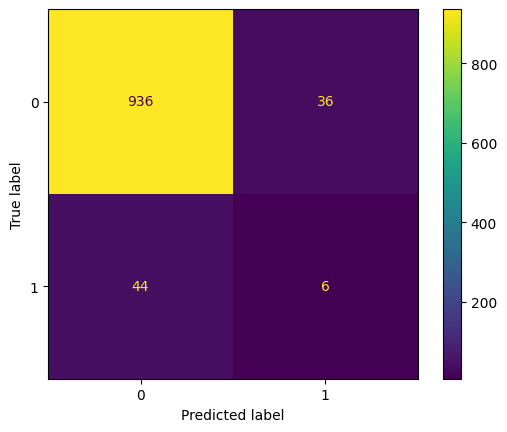

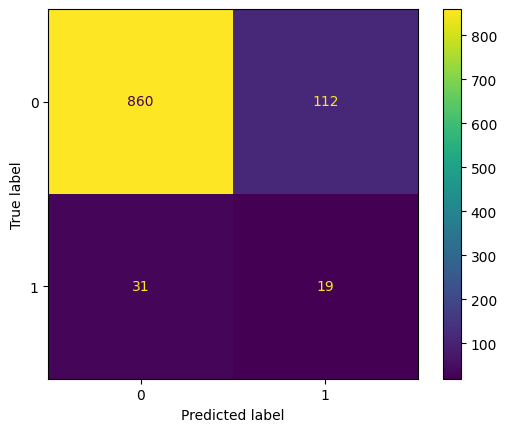

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

for name, clf in [
    ('Random Forest', RandomForestClassifier(random_state=0)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=0))
]:
  clf.fit(X_train_bal, y_train_bal)
  y_pred = clf.predict(X_test_p)

  print(f'=== {name} ===')
  print('Accuracy :', accuracy_score(y_test, y_pred))
  print('Precision:', precision_score(y_test, y_pred))
  print('Recall   :', recall_score(y_test, y_pred))
  ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
  print('\n')

=== Random Forest w/ RFE ===

Selected features: ['ever_married_Yes' 'work_type_Private' 'age' 'avg_glucose_level' 'bmi'] 

Accuracy : 0.8610567514677103
Precision: 0.12903225806451613
Recall   : 0.32


=== Gradient Boosting w/ RFE ===

Selected features: ['work_type_Govt_job' 'smoking_status_Unknown' 'age' 'avg_glucose_level'
 'bmi'] 

Accuracy : 0.8238747553816047
Precision: 0.14285714285714285
Recall   : 0.52




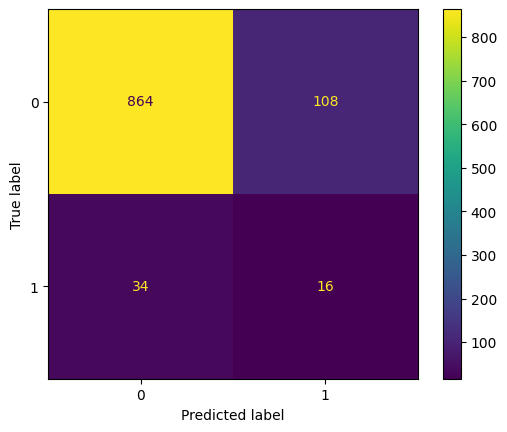

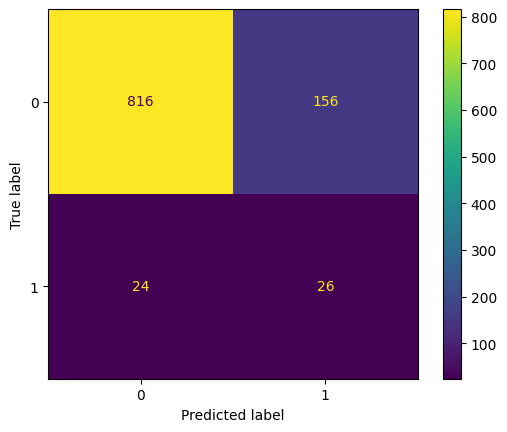

In [ ]:
from sklearn.feature_selection import RFE

fs_model_dict = {}

for name, clf in [
    ('Random Forest', RandomForestClassifier(random_state=0)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=0))
]:
  selector = RFE(clf, n_features_to_select=5, step=1)
  selector.fit(X_train_bal, y_train_bal)

  feature_names = preprocessor.get_feature_names_out()
  print(f'=== {name} w/ RFE ===')
  print('\nSelected features:', feature_names[selector.support_], '\n')

  X_test_fs  = selector.transform(X_test_p)
  y_pred_fs  = selector.estimator_.predict(X_test_fs)

  print('Accuracy :', accuracy_score(y_test, y_pred_fs))
  print('Precision:', precision_score(y_test, y_pred_fs))
  print('Recall   :', recall_score(y_test, y_pred_fs))
  ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_fs), display_labels=selector.estimator_.classes_).plot()
  print('\n')

  fs_model_dict[name] = selector

In [ ]:
import pickle
pickle.dump(fs_model_dict['Gradient Boosting'].estimator_, open('model.pkl', 'wb'))